In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers
from scipy import interpolate
import zipfile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Input, Dense, concatenate
from keras.models import Model

In [ ]:
# If you work on google colab, mount your google drive to download the data
# If you work on kaggle notbook you can directly download the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Done


In [ ]:
def interp(t_from, t_to, x_from):
    result = np.zeros((len(t_to), x_from.shape[1]))
    for k in range(x_from.shape[1]):
        f = interpolate.interp1d(t_from, x_from[:, k], fill_value = 'extrapolate')
        result[:, k] = f(t_to)
    return result

def load_landmarks(landmarks_path, max_len):
        """return landmarks & a list specifying if landmarks are available for each frame"""
        with open("data_train/{}".format(landmarks_path)) as f:
            lines = f.readlines()
        landmarks = []
        is_available = []
        for line in lines:
            lands = list(filter(lambda x: len(x), line.strip('\n').strip(' ').split(';')))
            if len(lands):
                is_available.append(True)
                landmarks.append(lands)
            else:
                is_available.append(False)
        landmarks = np.array(landmarks).astype('float32')   
        is_available = np.asarray(is_available)
        
        t_from = np.linspace(0, max_len-1, len(is_available))
        t_to = np.linspace(0, max_len-1, max_len)
        t_from = t_from[is_available]
        x_from = landmarks
        a = interp(t_from, t_to, x_from)
        return a

def load_landmarks_test(landmarks_path, max_len):
        """return landmarks & a list specifying if landmarks are available for each frame"""
        with open("data_test/{}".format(landmarks_path)) as f:
            lines = f.readlines()
        landmarks = []
        is_available = []
        for line in lines:
            lands = list(filter(lambda x: len(x), line.strip('\n').strip(' ').split(';')))
            if len(lands):
                is_available.append(True)
                landmarks.append(lands)
            else:
                is_available.append(False)
        landmarks = np.array(landmarks).astype('float32')   
        is_available = np.asarray(is_available)
        
        t_from = np.linspace(0, max_len-1, len(is_available))
        t_to = np.linspace(0, max_len-1, max_len)
        t_from = t_from[is_available]
        x_from = landmarks
        a = interp(t_from, t_to, x_from)
        return a
  
def get_files(path):
        """get data files paths"""
        with open(path, 'r') as f:
            files = f.readlines()
        return files

annotation_path = 'data_train/train_annotations.txt'
test_path = 'data_test/test_annotations.txt'

file = get_files(annotation_path)
test_file = get_files(test_path)  

In [ ]:
outpaths=['landmarks/train_gesture_landmarks1497.txt',
          'landmarks/train_gesture_landmarks2962.txt',
          'landmarks/train_gesture_landmarks2988.txt']
n = len(file)-3
max_len = 60
lands = np.zeros((n, max_len, 63)) 
i = 0
labels = np.zeros((n))
for f in file:
  video, land, label, size = f.split(', ')
  if land not in outpaths:
    lands[i,...] = load_landmarks(land, max_len)
    labels[i] = int(label)
    i+=1

outpaths=['landmarks/test_gesture_landmarks10.txt',
          'landmarks/test_gesture_landmarks14.txt',
          'landmarks/test_gesture_landmarks16.txt',
          'landmarks/test_gesture_landmarks27.txt',
          'landmarks/test_gesture_landmarks31.txt',
          'landmarks/test_gesture_landmarks33.txt']
n_test = len(test_file)-6

lands_test = np.zeros((n_test, max_len, 63))
i = 0
list_id = []
#labels = np.zeros((n_test))
for f in test_file:
    video, land, size = f.split(', ')
    if land not in outpaths:
      lands_test[i,...] = load_landmarks_test(land, max_len)
      #labels[i] = int(label)
      list_id.append(land)
      i+=1
list_id2 = []
for i in list_id:
    b = i.split('landmarks')
    c = b[2].split('.')
    #print(c)
    list_id2.append(c[0])


In [ ]:

import pdb
Victor = True
re_train = False
if Victor:
  time_step=1
  list_features=[]
  dist = np.zeros((lands.shape[0], max_len,210 ))
  dist_lands = np.zeros((lands.shape[0], 273, max_len))
  area = np.zeros((lands.shape[0], max_len,1330))
  angle = np.zeros((lands.shape[0],  max_len,3990))
  k = 0
  for land in lands:
    dist_matrix=[]
    for i in range(21):
      for j in range(i+1,21):
        dist_matrix.append(np.sum((land[::time_step,3*i:3*i+3]-land[::time_step,3*j:3*j+3])**2,axis=1))
  
    dist_matrix=np.array(dist_matrix)
    dist_lands[k, :210, :] = dist_matrix
    dist_lands[k, 210:, :] = land.T
    dist[k] = dist_matrix.T
    k+=1

  diff_lands = np.diff(lands, axis = 1)
  diff_lands_test = np.diff(lands_test, axis = 1)
  if re_train :
    l=0
    for land in lands:
      area_matrix=[]
      angle_matrix=[]
      for i in range(21):
        for j in range(i+1,21):
          for k in range(j+1,21):
            pt1 = land[::time_step,3*i:3*i+3]
            pt2 = land[::time_step,3*j:3*j+3]
            pt3 = land[::time_step,3*k:3*k+3]
            a= np.sqrt(np.sum((pt3-pt1)**2,axis=1))
            b= np.sqrt(np.sum((pt2-pt1)**2,axis=1))
            c= np.sqrt(np.sum((pt3-pt2)**2,axis=1))
            p = (a+b+c)/2
            aire = np.sqrt(p*(p-a)*(p-b)*(p-c))
            area_matrix.append(aire)
            angle_matrix.append(np.sum(pt2*pt1,axis=1)*(1/(np.sqrt((np.sum(pt1*pt1,axis=1)*np.sum(pt2*pt2,axis=1))))))
            angle_matrix.append(np.sum(pt3*pt1,axis=1)*(1/(np.sqrt((np.sum(pt1*pt1,axis=1)*np.sum(pt3*pt3,axis=1))))))
            angle_matrix.append(np.sum(pt2*pt3,axis=1)*(1/(np.sqrt((np.sum(pt3*pt3,axis=1)*np.sum(pt2*pt2,axis=1))))))
      angle_matrix=np.array(angle_matrix).T 
      area_matrix=np.array(area_matrix).T 
      angle[l]= angle_matrix
      area[l] = area_matrix
      l+=1

  # X = dist_lands
  # y = labels
  # X_train=X[:2000]
  # X_val=X[2000:]
  # y_train=labels[:2000]
  # y_val=labels[2000:]

In [ ]:
area = np.load('/content/drive/MyDrive/Data/DataChallenge/area.npy')
angle = np.load('/content/drive/MyDrive/Data/DataChallenge/angle.npy')

In [ ]:
X1 = lands
X2 = dist
X3 = diff_lands
X4 = area
X5 = angle
y = labels
X1_train = X1[:2000]
X1_val = X1[2000:]
X2_train = X2[:2000]
X2_val = X2[2000:]
X3_train = X3[:2000]
X3_val = X3[2000:]
X4_train = X4[:2000]
X4_val = X4[2000:]
X5_train = X5[:2000]
X5_val = X5[2000:]
y_train = labels[:2000]
y_val = labels[2000:]


def to_cat(label):
  li=np.zeros((13))
  li[label-1]=1
  return li

y_train2,y_val2=[],[]

for u in y_train:
  y_train2.append(to_cat(int(u)))

y_train2a=np.array(y_train2)

# Modèle


In [ ]:
def create_clf(max_len):
 # create model
  model = Sequential()
  model.add(Conv1D(filters=50, kernel_size=7, activation='selu', input_shape=(max_len,63)))
  # model.add(Conv1D(filters=150, kernel_size=7, activation='relu'))
  model.add(MaxPooling1D(pool_size=3))
  model.add(Conv1D(filters=300, kernel_size=7, activation='relu'))
  model.add(Dropout(0.4))
  model.add(MaxPooling1D(pool_size=3))
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(400, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(100, activation='relu'))
  
  model.add(layers.Dense(13,activation='softmax'))
 # Compile model
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
  print(model.summary())
  return model


clf1=create_clf(max_len)
hist =clf1.fit(X_train,y_train2a,epochs=100,validation_split=0.33)


#Modèle suite


In [ ]:
def create_clf(max_len,size_features):
 # create model
 #Model A
  input_lands = Input(shape=(max_len,63), name="Input_a")
  x= Conv1D(filters=64, kernel_size=7, activation='selu', input_shape=(max_len,63))(input_lands)
  x= Conv1D(filters=128, kernel_size=5, activation='relu')(x)
  x= MaxPooling1D(pool_size=3)(x)
  x= Conv1D(filters=256, kernel_size=5, activation='relu')(x)
  x= Dropout(0.5)(x)
  x= MaxPooling1D(pool_size=3)(x)
  x= Flatten()(x)
  x= Dropout(0.5)(x)
  x= Dense(400, activation='relu')(x)
  x= Dropout(0.5)(x)
  output_lands= Dense(100, activation='relu')(x)
  
  # output_clf = Dense(13,activation='softmax')(x)
  # model = Model(inputs=[input_clf],outputs=[output_clf], name = "Model_Nio")

  #Model B
  input_dist = Input(shape=(max_len,210), name="Input_b")
  y= Conv1D(filters=64, kernel_size=7, activation='selu', input_shape=(max_len,210))(input_dist)
  y= Conv1D(filters=128, kernel_size=5, activation='relu')(y)
  y= MaxPooling1D(pool_size=3)(y)
  y= Conv1D(filters=256, kernel_size=5, activation='relu')(y)
  y= Dropout(0.5)(y)
  y= MaxPooling1D(pool_size=3)(y)
  y= Flatten()(y)
  y= Dropout(0.5)(y)
  y= Dense(300, activation='relu')(y)
  y= Dropout(0.5)(y)
  output_dist= Dense(100, activation='relu')(y)

  input_diff = Input(shape=(max_len-1,63), name="Input_c")
  z= Conv1D(filters=64, kernel_size=7, activation='selu', input_shape=(max_len-1,63))(input_diff)
  z= Conv1D(filters=128, kernel_size=5, activation='relu')(z)
  z= MaxPooling1D(pool_size=3)(z)
  z= Conv1D(filters=256, kernel_size=5, activation='relu')(z)
  z= Dropout(0.5)(z)
  z= MaxPooling1D(pool_size=3)(z)
  z= Flatten()(z)
  z= Dropout(0.5)(z)
  z= Dense(300, activation='relu')(z)
  z= Dropout(0.5)(z)
  output_diff= Dense(100, activation='relu')(z)

  input_area = Input(shape=(max_len,1330), name="Input_d")
  a= Conv1D(filters=64, kernel_size=7, activation='selu', input_shape=(max_len,1330))(input_area)
  a= Conv1D(filters=128, kernel_size=5, activation='relu')(a)
  a= MaxPooling1D(pool_size=3)(a)
  a= Conv1D(filters=256, kernel_size=5, activation='relu')(a)
  a= Dropout(0.5)(a)
  a= MaxPooling1D(pool_size=3)(a)
  a= Flatten()(a)
  a= Dropout(0.5)(a)
  a= Dense(300, activation='relu')(a)
  a= Dropout(0.5)(a)
  output_area= Dense(100, activation='relu')(a)

  input_angle = Input(shape=(max_len,3*1330), name="Input_e")
  b= Conv1D(filters=64, kernel_size=7, activation='selu', input_shape=(max_len,3*1330))(input_angle)
  b= Conv1D(filters=128, kernel_size=5, activation='relu')(b)
  b= MaxPooling1D(pool_size=3)(b)
  b= Conv1D(filters=256, kernel_size=5, activation='relu')(b)
  b= Dropout(0.5)(b)
  b= MaxPooling1D(pool_size=3)(b)
  b= Flatten()(b)
  b= Dropout(0.5)(b)
  b= Dense(400, activation='relu')(b)
  b= Dropout(0.5)(b)
  output_angle= Dense(100, activation='relu')(b)
  
  a_b = concatenate([output_lands,output_dist, output_diff, output_area],name="concatenated_layer")
  last_layer = Dense(100, activation='relu')(a_b)
  output_layer = Dense(13, activation = "softmax", name = "output_layer")(last_layer)

  model = Model(inputs=[(input_lands,input_dist, input_diff, input_area)],outputs=[output_layer], name = "merged_model")

 # Compile model
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
  model.summary()
  keras.utils.plot_model(model, "architecture.png", show_shapes=True)
  return model

# def create_clf_Rocket(size_kernel):
#     model = Sequential()
#     model.add(Dense(250, activation='relu',input_shape=(size_kernel*2,)))
#     model.add(Dropout(0.5))
#     model.add(Dense(70, activation='relu'))
#     return(model)

clf1=create_clf(max_len,3780)
# hist =clf1.fit(x=[X1_train,X2_train, X3_train, X4_train, X5_train],y=y_train2a,epochs=100,validation_split=0.33)

# create_clf_Rocket(1870).summary()

Model: "merged_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_a (InputLayer)           [(None, 60, 63)]     0           []                               
                                                                                                  
 Input_b (InputLayer)           [(None, 60, 210)]    0           []                               
                                                                                                  
 Input_c (InputLayer)           [(None, 59, 63)]     0           []                               
                                                                                                  
 Input_d (InputLayer)           [(None, 60, 1330)]   0           []                               
                                                                                       

In [ ]:
!pip install visualkeras


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 KB 58.8 MB/s eta 0:00:00


In [ ]:
def create_clf(max_len,size_features):
 # create model
 #Model A
  input_lands = Input(shape=(max_len,63), name="Input_a")
  x= Conv1D(filters=64, kernel_size=7, activation='selu', input_shape=(max_len,63))(input_lands)
  x= Conv1D(filters=128, kernel_size=5, activation='relu')(x)
  x= MaxPooling1D(pool_size=3)(x)
  x= Conv1D(filters=256, kernel_size=5, activation='relu')(x)
  x= Dropout(0.5)(x)
  x= MaxPooling1D(pool_size=3)(x)
  x= Flatten()(x)
  x= Dropout(0.5)(x)
  x= Dense(400, activation='relu')(x)
  x= Dropout(0.5)(x)
  output_lands= Dense(100, activation='relu')(x)
  
  

  model = Model(inputs=[input_lands],outputs=[output_lands], name = "merged_model")

 # Compile model
  # model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
  # model.summary()
  keras.utils.plot_model(model, "architecture.png", show_shapes=True)
  return model


clf1=create_clf(max_len,3780)

# create_clf_Rocket(1870).summary()

In [ ]:
!pip install visualkeras
import visualkeras
import tensorflow as tf
from tensorflow.keras import layers
from collections import defaultdict

color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = '#00f5d4'
color_map[layers.MaxPooling2D]['fill'] = '#8338ec'
color_map[layers.Dropout]['fill'] = '#03045e'
color_map[layers.Dense]['fill'] = '#fb5607'
color_map[layers.Flatten]['fill'] = '#ffbe0b'
visualkeras.layered_view(clf1, legend=True, draw_volume=False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


TypeError: ignored

In [ ]:
clf1.summary()

Model: "merged_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_e (InputLayer)        [(None, 60, 19)]          0         
                                                                 
 conv1d_27 (Conv1D)          (None, 54, 64)            8576      
                                                                 
 conv1d_28 (Conv1D)          (None, 50, 128)           41088     
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 16, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_29 (Conv1D)          (None, 12, 256)           164096    
                                                                 
 dropout_27 (Dropout)        (None, 12, 256)           0         
                                                      

In [ ]:
def scheduler(epoch, lr):
  if epoch < 70:
    return lr
  else:
    return lr * tf.math.exp(-0.05)

checkpoint_filepath = 'checkpoint/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

hist =clf1.fit(x=[X1_train,X2_train, X3_train, X4_train],y=y_train2a,epochs=100,validation_split=0.33,callbacks=[model_checkpoint_callback,callback],shuffle=False)

clf1.load_weights(checkpoint_filepath)

Epoch 1/100
42/42 [==============================] - 69s 59ms/step - loss: 1.6221 - accuracy: 0.4361 - val_loss: 1.3071 - val_accuracy: 0.5658 - lr: 0.0010
Epoch 2/100
42/42 [==============================] - 2s 54ms/step - loss: 1.0867 - accuracy: 0.6131 - val_loss: 1.1436 - val_accuracy: 0.6021 - lr: 0.0010
Epoch 3/100
42/42 [==============================] - 2s 39ms/step - loss: 0.8573 - accuracy: 0.6826 - val_loss: 0.8350 - val_accuracy: 0.7247 - lr: 0.0010
Epoch 4/100
42/42 [==============================] - 1s 34ms/step - loss: 0.6899 - accuracy: 0.7640 - val_loss: 0.6927 - val_accuracy: 0.7443 - lr: 0.0010
Epoch 5/100
42/42 [==============================] - 1s 32ms/step - loss: 0.5571 - accuracy: 0.8073 - val_loss: 0.6479 - val_accuracy: 0.7867 - lr: 0.0010
Epoch 6/100
42/42 [==============================] - 1s 32ms/step - loss: 0.6012 - accuracy: 0.7886 - val_loss: 0.6420 - val_accuracy: 0.7988 - lr: 0.0010
Epoch 7/100
42/42 [==============================] - 1s 34ms/step - l

In [ ]:
np.shape(X2) 

(3114, 210, 60)

# Test

In [ ]:
def create_clf(max_len,size_features):
 # create model
 #Model A
  input_clf = Input(shape=(max_len,63), name="Input_a")
  x= Conv1D(filters=64, kernel_size=7, activation='selu', input_shape=(max_len,63))(input_clf)
  x= Conv1D(filters=128, kernel_size=5, activation='relu')(x)
  x= MaxPooling1D(pool_size=3)(x)
  x= Conv1D(filters=256, kernel_size=5, activation='relu')(x)
  x= Dropout(0.5)(x)
  x= MaxPooling1D(pool_size=3)(x)
  x= Flatten()(x)
  x= Dropout(0.5)(x)
  x= Dense(400, activation='relu')(x)
  x= Dropout(0.5)(x)
  output_clf= Dense(100, activation='relu')(x)
  
  # output_clf = Dense(13,activation='softmax')(x)
  # model = Model(inputs=[input_clf],outputs=[output_clf], name = "Model_Nio")

  #Model B
  input_features = Input(shape=(size_features,), name="Input_b")
  y= Dense(350, activation='selu')(input_features)
  y= Dropout(0.15)(y)
  output_features = Dense(100, activation='relu')(y)

  a_b = concatenate([output_clf,output_features],name="concatenated_layer")

  output_layer = Dense(13, activation = "softmax", name = "output_layer")(a_b)

  model = Model(inputs=[(input_clf,input_features)],outputs=[output_layer], name = "merged_model")

 # Compile model
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
  model.summary()
  keras.utils.plot_model(model, "architecture.png", show_shapes=True)
  return model

# def create_clf_Rocket(size_kernel):
#     model = Sequential()
#     model.add(Dense(250, activation='relu',input_shape=(size_kernel*2,)))
#     model.add(Dropout(0.5))
#     model.add(Dense(70, activation='relu'))
#     return(model)

clf1=create_clf(max_len,3780)
hist =clf1.fit(x=[X_train,X_train_Rocket],y=y_train2a,epochs=100,validation_split=0.33)

# create_clf_Rocket(1870).summary()

Model: "merged_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_a (InputLayer)           [(None, 60, 63)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 54, 64)       28288       ['Input_a[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 50, 128)      41088       ['conv1d[0][0]']                 
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 16, 128)      0           ['conv1d_1[0][0]']               
                                                                                       

NameError: ignored

# Résultat

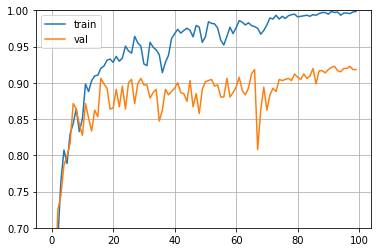

In [ ]:
plt.plot(hist.history['accuracy'],label="train")
plt.plot(hist.history['val_accuracy'],label="val")
plt.ylim(0.7,1)
plt.grid()
plt.legend()
plt.show()

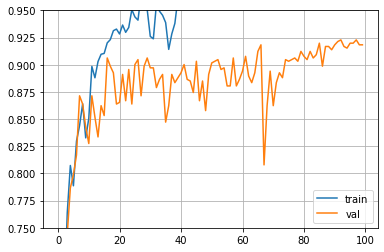

In [ ]:
plt.plot(hist.history['accuracy'],label="train")
plt.plot(hist.history['val_accuracy'],label="val")
plt.ylim(0.75,0.95)
plt.grid()
plt.legend()
plt.show()

... sur le set de Validation

... sur le set de Test

In [ ]:
y_pred_val=np.argmax(clf1.predict([X1_val,X2_val,X3_val,X4_val]),axis=1)
pred = np.argmax(clf1.predict([lands_test,dist_test,diff_lands_test]),axis=1)+1
for i in range(len(y_pred_val)):
  y_pred_val[i]+=1

y_pred_test=np.argmax(clf1.predict([]),axis=1)

for i in range(len(y_pred_test)):
  y_pred_test[i]+=1

print(y_pred_test[:5])

35/35 [==============================] - 1s 11ms/step


In [ ]:
np.sum((y_pred_val==y_val))/len(y_val)

0.7989228007181328

Résultats

In [ ]:
df = pd.DataFrame(columns = ['Id', 'Gesture'])
for i in range(len(y_pred_test)):
  df.loc[i, :] = [int(list_id2[i]), int(y_pred_test[i])]

#Prédictions sans landmarks
df.loc[1095,:] = [10, 1]
df.loc[1096, :] = [14, 1]
df.loc[1097, :] = [16, 1]
df.loc[1098, :] = [27, 1]
df.loc[1099, :] = [31, 1]
df.loc[1100, :] = [33, 1]

df.sort_values('Id', inplace = True)
df.to_csv("result.csv", index = False)